# Predict household poverty from satellite imagery data

Using code from run_grid.py, adjust the process to include feature extraction using CNN and changing target to poverty levels.
***
**ML pipeline steps in detail here:**  
1. Import and prep data  
    - Import BISP data  
    - Choose transformation for target variable (poverty)  
    - Import NTL (viirs) data  
    - Match BISP HHs to coordinates  
    - Join Bisp data and NTL data  
    - Map DTL image files to data  
<br>
2. Use CNN to extract features from DTL  
    - Prep DTL, load CNN, and extract features  
    - Select extracted features to include using PCA  
    - Add selected extracted features to data   
<br>
3. Split data into test/train sets  
***
**ML pipline steps handled by run_grid.py:** 
4. Train and evaluate models (run grid search). For each regressor-hyperparameter combination:  
    - Train regressor with given hyperparameters and training data and labels
    - Generate predicted labels for test data with trained regressor
    - Evaluate regressor-hyperparameter performance against actual test labels

In [91]:
import os
import math
import pickle
import numpy as np
import pandas as pd 
import geopandas as gpd

from sklearn.preprocessing import KBinsDiscretizer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

# Specify autoreload
%load_ext autoreload
%autoreload 2

# Import configuration file and feature extraction file
import config as cf
import feature_extraction as fe

# Turn off big pink warnings
import warnings
warnings.filterwarnings('ignore')

# Display options 
pd.options.display.max_columns = 999
pd.options.display.max_colwidth = -1 

# Data file path 
# final_data_file_path = "/Users/robmarty/Dropbox/World Bank/IEs/Pakistan Poverty Estimation from Satellites/Data/FinalData"

# Set directory
os.chdir("/Users/nguyenluong/wb_internship/Data")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Import data and prep data

### 1.1 Import BISP data

In [43]:
#### Predict Changes
# DATA_PATH = os.path.join(final_data_file_path, 'BISP','Merged Datasets', 'bisp_socioeconomic_satellite_firstdiff_r13.csv')
# DATA_PATH = os.path.join('/Users/robmarty/Desktop/', 'bisp_socioeconomic_satellite_firstdiff_r13.csv')

#### Predict Levels
DATA_PATH = os.path.join('BISP', 'bisp_socioeconomic_satellite_panel_full_satPovNAsRemoved_1hh.csv')

df = pd.read_csv(DATA_PATH)
df.shape

(4528, 502)

In [44]:
# Restrict to Year
df = df[df['year'] == 2014]
df.shape

(3273, 502)

### 1.2 Choose transformation for target (poverty)

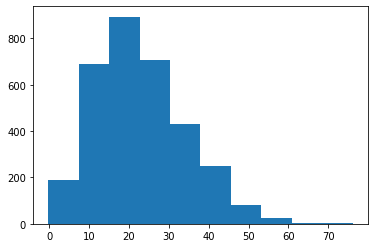

In [19]:
# Look at distribution
plt.hist(df['pscores']);

In [45]:
### Changes
#df['pscores_bin'] = df['pscores'] < 0

#### Levels
#df = df.loc[df['survey_round'] != 1]
#df['pscores_bin'] = df['pscores'] <= (df['pscores'].median())
#df['pscores_bin'] = df['pscores_poor']

### Target as Quantiles
#df['pscores_bin'] = pd.qcut(df['pscores'], 4, labels=False)
#df['pscores_2011'].value_counts()
#df['pscores_bin'] = df['pscores'] < 0

### Clustered by K-Means
#pscores = df['pscores'].to_numpy().reshape(-1,1)
#discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='kmeans')
#df['pscores_bin'] = discretizer.fit_transform(pscores)

### Binary
df['in_poverty'] = (df['pscores']<=16.17)
df['in_poverty'] = df['in_poverty'].astype(int)

df.in_poverty.value_counts()

0    2248
1    1025
Name: in_poverty, dtype: int64

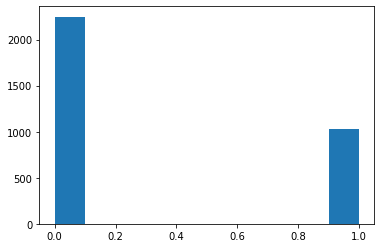

In [46]:
plt.hist(df['in_poverty']);

### 1.3 Import NTL data

In [48]:
# Load satellite data
viirs_gdf = gpd.read_file('satellite_raw/VIIRS/viirs_annual_polygon.geojson')
viirs_gdf = viirs_gdf[['median_rad_2014', 'tile_id', 'geometry']]
viirs_gdf.head(2)

,median_rad_2014,tile_id,geometry
0,0.179258,42.0,"POLYGON ((74.66347 37.06224, 74.67021 37.06224, 74.67021 37.05551, 74.66347 37.05551, 74.66347 37.06224))"
1,0.207353,42.0,"POLYGON ((74.67021 37.06224, 74.67695 37.06224, 74.67695 37.05551, 74.67021 37.05551, 74.67021 37.06224))"


### 1.4 Match BISP HHs to Coordinates

In [49]:
# Load BISP coordinate info
coords = pd.read_stata('BISP/GPS_uid_crosswalk.dta')

from math import floor
def get_lat_lon(number):
    deg = floor(number / 100)
    min = floor(number - (100 * deg))
    sec = 100 * (number - (100 * deg) - min)
    degree = deg + (min / 60) + (sec / 3600)
    return degree

# Drop NAs
coords = coords[~coords['GPSN'].isna()]

# Get lat, lon
coords['lat'] = coords['GPSN'].apply(lambda x: get_lat_lon(x))
coords['lon'] = coords['GPSE'].apply(lambda x: get_lat_lon(x))

# Convert uid to integer
coords['uid'] = coords['uid'].astype(int)

# Create geopandas
coords = gpd.GeoDataFrame(coords, geometry=gpd.points_from_xy(coords['lon'], coords['lat']))
coords.head()

,GPSN,GPSE,uid,lat,lon,geometry
0,3349.405,7241.680,104989,33.827917,72.702222,POINT (72.70222 33.82792)
1,3349.403,7241.698,100389,33.827861,72.702722,POINT (72.70272 33.82786)
2,3349.392,7241.730,101236,33.827556,72.703611,POINT (72.70361 33.82756)
3,3349.383,7241.486,105557,33.827306,72.696833,POINT (72.69683 33.82731)
4,3349.370,7241.639,101915,33.826944,72.701083,POINT (72.70108 33.82694)


In [50]:
# Match coords to HHs in df
gdf_bisp = coords.merge(df, left_on='uid', right_on='uid')
gdf_bisp.shape

(3273, 508)

### 1.5 Join Bisp data and NTL data
Bisp HHs located in an NTL tile/poly are linked to that NTL radiance value 

In [51]:
# Spatial join HHs with satellite viirs
gdf = gpd.sjoin(viirs_gdf, gdf_bisp, how="inner", op='intersects').reset_index(drop=True)
# Reset index because multiple HHs may belong to one NTL tile

In [52]:
# Inspect range of tiles represented
print(gdf.shape)
print(sorted(gdf['tile_id'].unique()))

(3259, 511)
[1.0, 2.0, 8.0, 9.0, 10.0, 13.0, 14.0, 15.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 36.0, 37.0, 38.0, 40.0]


### 1.6 Map DTL image files to data

In [53]:
DTL_directory = os.path.join('satellite_raw', 'Landsat', '2014')
DLT, processed_gdf = fe.map_DTL_NTL(gdf, DTL_directory)

In [54]:
print(processed_gdf.shape)
print('Note: {} observations were dropped due to irregular DTL sizes'.format(gdf.shape[0] - processed_gdf.shape[0]))

(3259, 511)
Note: 0 observations were dropped due to irregular DTL sizes


In [15]:
# Feature Columns
df_viirs = processed_gdf.filter(regex='viirs').filter(regex='_2km')
df_landsat = processed_gdf.filter(regex='^b').filter(regex='_1km')
df_osm = processed_gdf.filter(regex='fclass').filter(regex='meters')
df_facebook = processed_gdf.filter(regex='^estimate_dau')

# Target Column
df_y = processed_gdf[['uid', 'pscores', 'in_poverty']]

# Final df
df_final = df_y.join(df_osm).join(df_facebook).join(df_landsat).join(df_viirs).reset_index(drop=True)

# 2. Use CNN to extract features from DTL

### 2.1 Prep DTL, load CNN, and extract features

In [56]:
# Reshape DTL like in CNN training
height, width, channels = 25, 26, 7
DLT = DLT.reshape((DLT.shape[0], height, width, channels))
print('DTL after reshaping: {}'.format(DLT.shape))

DTL after reshaping: (3259, 25, 26, 7)


In [129]:
### Save objects for later
#gdf_bisp.to_pickle('saved_objects/gdf_bisp.pkl') #bisp data with Point geometry
#processed_gdf.to_pickle('saved_objects/processed_gdf.pkl') #bisp + viirs data + Polygon geometry
#df_final.to_pickle('saved_objects/df_final.pkl') #final df with binary target
#np.save('saved_objects/poverty_DLT', DLT)
#viirs_gdf.to_pickle('saved_objects/viirs_gdf.pkl')

### Restart here
gdf_bisp = pd.read_pickle('saved_objects/gdf_bisp.pkl')
processed_gdf = pd.read_pickle('saved_objects/processed_gdf.pkl')
df_final = pd.read_pickle('saved_objects/df_final.pkl') 
DLT = np.load('saved_objects/poverty_DLT.npy')
viirs_gdf = pd.read_pickle('saved_objects/viirs_gdf.pkl')

In [131]:
# Load CNN
from keras.models import load_model
model = load_model('best_CNN.h5')
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 21, 22, 64)        11264     
_________________________________________________________________
maxpool1 (MaxPooling2D)      (None, 10, 11, 64)        0         
_________________________________________________________________
flatten1 (Flatten)           (None, 7040)              0         
_________________________________________________________________
dense1 (Dense)               (None, 100)               704100    
_________________________________________________________________
dense2 (Dense)               (None, 5)                 505       
Total params: 715,869
Trainable params: 715,869
Non-trainable params: 0
_________________________________________________________________


In [132]:
# Extract features
df_features = fe.extract_features(model, DLT, 'dense1')
df_features

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,feat_11,feat_12,feat_13,feat_14,feat_15,feat_16,feat_17,feat_18,feat_19,feat_20,feat_21,feat_22,feat_23,feat_24,feat_25,feat_26,feat_27,feat_28,feat_29,feat_30,feat_31,feat_32,feat_33,feat_34,feat_35,feat_36,feat_37,feat_38,feat_39,feat_40,feat_41,feat_42,feat_43,feat_44,feat_45,feat_46,feat_47,feat_48,feat_49,feat_50,feat_51,feat_52,feat_53,feat_54,feat_55,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64,feat_65,feat_66,feat_67,feat_68,feat_69,feat_70,feat_71,feat_72,feat_73,feat_74,feat_75,feat_76,feat_77,feat_78,feat_79,feat_80,feat_81,feat_82,feat_83,feat_84,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,feat_94,feat_95,feat_96,feat_97,feat_98,feat_99
0,0.0,0.0,0.0,2078.216797,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,1697.983398,0.0,0.0,0.000000,1473.291626,826.142334,0.0,0.0,0.0,0.0,876.303772,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,593.273987,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,2454.766357,0.0,3466.903809,550.257568,0.00000,0.0,0.0,0.000000,704.017395,713.016357,1698.519409,0.000000,0.000000,809.686218,0.0,0.0,1858.261230,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,5320.941406,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,2154.061523,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,375.566833,880.228943,0.0,1721.483398
1,0.0,0.0,0.0,0.000000,77.971481,227.652298,494.634735,0.0,0.0,0.0,0.0,15.366259,111.620102,0.000000,0.0,0.0,0.000000,1376.690674,1178.718140,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,532.434631,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,4.344375,0.0,172.028961,0.000000,481.96524,0.0,0.0,95.996819,955.976501,0.000000,384.538727,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,663.467529,0.0,0.0,0.0,0.0,0.0,3115.863281,0.000000,0.0,0.0,0.0,0.000000,534.530518,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.063496,0.0,0.0,515.100342,0.000000,0.000000,0.0,448.425934
2,0.0,0.0,0.0,0.000000,0.000000,43.338295,0.000000,0.0,0.0,0.0,0.0,7.767977,0.000000,0.000000,0.0,0.0,0.000000,116.873428,164.494888,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,10.511365,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.0,140.947861,0.000000,0.000000,239.845703,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,104.422516,0.0,0.0,0.0,0.0,0.0,1223.804932,0.000000,0.0,0.0,0.0,0.000000,137.153534,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,360.021118,0.000000,0.000000,0.0,0.000000
3,0.0,0.0,0.0,0.000000,0.000000,43.338295,0.000000,0.0,0.0,0.0,0.0,7.767977,0.000000,0.000000,0.0,0.0,0.000000,116.873428,164.494888,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,10.511365,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.0,140.947861,0.000000,0.000000,239.845703,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,104.422516,0.0,0.0,0.0,0.0,0.0,1223.804932,0.000000,0.0,0.0,0.0,0.000000,137.153534,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,360.021118,0.000000,0.000000,0.0,0.000000
4,0.0,0.0,0.0,0.000000,0.000000,43.338295,0.000000,0.0,0.0,0.0,0.0,7.767977,0.000000,0.000000,0.0,0.0,0.000000,116.873428,164.494888,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,10.511365,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.0,140.947861,0.000000,0.000000,239.845703,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,104.422516,0.0,0.0,0.0,0.0,0.0,1223.804932,0.000000,0.0,0.0,0.0,0.000000,137.153534,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,360.021118,0.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

### 2.2 Select extracted features to include using PCA

In [133]:
pca = PCA(n_components=10)
pca.fit(df_features)
print('Explained variance ratio: {}'.format(pca.explained_variance_ratio_))

features_pca = pca.transform(df_features)
column_names = ['pc_%01d' %i for i in range(0,10)]
df_features_pca = pd.DataFrame(data=features_pca, columns=column_names)
df_features_pca

Explained variance ratio: [0.51215136 0.21327284 0.05961572 0.04426586 0.03543009 0.02348131
 0.01775925 0.01621351 0.00987017 0.00955147]


,pc_0,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,pc_9
0,5616.052246,4190.887695,1276.722290,-631.961243,2329.999512,-1627.386597,-1267.548462,1452.516846,1695.048462,960.472412
1,3082.897217,1248.506592,-8.313826,797.965332,-366.155090,-1152.810425,341.083099,-219.040390,199.383438,-975.496826
2,2013.003540,-667.683105,-66.913864,51.946198,79.527924,-216.621048,353.959290,-72.777435,290.582397,-216.210403
3,2013.003540,-667.683105,-66.913864,51.946198,79.527924,-216.621048,353.959290,-72.777435,290.582397,-216.210403
4,2013.003540,-667.683105,-66.913864,51.946198,79.527924,-216.621048,353.959290,-72.777435,290.582397,-216.210403
...,...,...,...,...,...,...,...,...,...,...
3254,1569.887207,-823.250000,-274.188019,39.881805,30.299898,230.218063,208.683701,248.541153,189.684570,-222.508759
3255,1569.887207,-823.250000,-274.188019,39.881805,30.299898,230.218063,208.683701,248.541153,189.684570,-222.508759
3256,1569.887207,-823.250000,-274.188019,39.881805,30.299898,230.218063,208.683701,248.541153,189.684570,-222.508759
3257,2505.014893,-63.966854,-140.643372,499.150146,-432.493713,126.828575,150.649017,357.401184,365.302429,-406.213287


### 2.3 Add selected extracted features to data

In [136]:
df_final = df_final.join(df_features_pca).drop(columns=['pscores'])

# 3. Split data into test/train and normalize

In [137]:
from imblearn.over_sampling import RandomOverSampler

LABEL = 'in_poverty'
TEST_SIZE = 0.2

# Save df
df_final.to_pickle('saved_objects/fully_prepped.pkl')

# Separate feature sets from label sets
x_df = df_final.drop(labels=[LABEL, 'uid'], axis=1)
y_df = df_final[LABEL]

# Oversample for more balanced data
oversample = RandomOverSampler(sampling_strategy=0.75, random_state=1)
x_df, y_df = oversample.fit_resample(x_df, y_df)

# Split into test and train sets for features and labels
x_train, x_test, y_train, y_test =  train_test_split(x_df, y_df, test_size=TEST_SIZE)

# Normalize
x_scaler = StandardScaler().fit(x_train)
for df in (x_train, x_test):
    x_scaler.transform(df)

In [138]:
x_train.head()

,dist_osm_fclass_tertiary_meters,dist_osm_fclass_secondary_meters,dist_osm_fclass_residential_meters,dist_osm_fclass_trunk_meters,dist_osm_fclass_primary_meters,dist_osm_fclass_unclassified_meters,dist_osm_fclass_service_meters,dist_osm_fclass_motorway_meters,dist_osm_fclass_living_street_meters,estimate_dau_all,estimate_dau_male,estimate_dau_female,b1_buff_1km_mean,b2_buff_1km_mean,b3_buff_1km_mean,b4_buff_1km_mean,b5_buff_1km_mean,b6_buff_1km_mean,b7_buff_1km_mean,b12_buff_1km_mean,b13_buff_1km_mean,b14_buff_1km_mean,b15_buff_1km_mean,b16_buff_1km_mean,b17_buff_1km_mean,b23_buff_1km_mean,b24_buff_1km_mean,b25_buff_1km_mean,b26_buff_1km_mean,b27_buff_1km_mean,b34_buff_1km_mean,b35_buff_1km_mean,b36_buff_1km_mean,b37_buff_1km_mean,b45_buff_1km_mean,b46_buff_1km_mean,b47_buff_1km_mean,b56_buff_1km_mean,b57_buff_1km_mean,b67_buff_1km_mean,b1_buff_1km_min,b2_buff_1km_min,b3_buff_1km_min,b4_buff_1km_min,b5_buff_1km_min,b6_buff_1km_min,b7_buff_1km_min,b12_buff_1km_min,b13_buff_1km_min,b14_buff_1km_min,b15_buff_1km_min,b16_buff_1km_min,b17_buff_1km_min,b23_buff_1km_min,b24_buff_1km_min,b25_buff_1km_min,b26_buff_1km_min,b27_buff_1km_min,b34_buff_1km_min,b35_buff_1km_min,b36_buff_1km_min,b37_buff_1km_min,b45_buff_1km_min,b46_buff_1km_min,b47_buff_1km_min,b56_buff_1km_min,b57_buff_1km_min,b67_buff_1km_min,b1_buff_1km_max,b2_buff_1km_max,b3_buff_1km_max,b4_buff_1km_max,b5_buff_1km_max,b6_buff_1km_max,b7_buff_1km_max,b12_buff_1km_max,b13_buff_1km_max,b14_buff_1km_max,b15_buff_1km_max,b16_buff_1km_max,b17_buff_1km_max,b23_buff_1km_max,b24_buff_1km_max,b25_buff_1km_max,b26_buff_1km_max,b27_buff_1km_max,b34_buff_1km_max,b35_buff_1km_max,b36_buff_1km_max,b37_buff_1km_max,b45_buff_1km_max,b46_buff_1km_max,b47_buff_1km_max,b56_buff_1km_max,b57_buff_1km_max,b67_buff_1km_max,viirs_spatialmean_monthlymean_buff_2km,viirs_spatialmean_monthlysd_buff_2km,viirs_spatialmax_monthlymean_buff_2km,viirs_spatialmax_monthlysd_buff_2km,viirs_spatialmin_monthlymean_buff_2km,viirs_spatialmin_monthlysd_buff_2km,viirs_spatialsd_monthlymean_buff_2km,viirs_spatialsd_monthlysd_buff_2km,pc_0,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,pc_9
1549,1888.417444,5097.683285,15841.082055,42720.994862,21179.742244,15091.368647,41585.776832,80754.306756,64837.119616,0,0,0,833.167680,1127.323197,1223.630177,2633.993339,2174.060817,2989.667391,1588.443238,0.150042,0.189840,0.519395,0.445890,0.564110,0.311890,0.040965,0.400570,0.317060,0.452356,0.169794,0.365604,0.279728,0.419158,0.129731,-0.095659,0.063246,-0.247618,0.157949,-0.155646,-0.306070,577.0,789.5,688.0,1875.0,1450.0,2960.0,830.0,0.155507,0.087747,0.529364,0.430686,0.673735,0.179815,-0.068697,0.407394,0.294932,0.578877,0.025008,0.463129,0.356408,0.622807,0.093544,-0.127820,0.224405,-0.386322,0.342404,-0.271930,-0.562005,1340.5,1782.5,2144.0,3692.0,3429.5,3077.0,3151.5,0.141531,0.230593,0.467263,0.437945,0.393096,0.403161,0.092067,0.348799,0.316002,0.266385,0.277463,0.265250,0.230645,0.178701,0.190256,-0.036860,-0.090855,-0.078980,-0.054177,-0.042243,0.011961,1.213209,0.447724,4.053895,1.838145,0.406510,0.116959,0.999498,0.496591,-1570.693848,623.331360,-119.366577,36.021698,33.799843,-320.253021,-5.897263,-336.637329,210.731445,-133.632370
2429,5922.229124,15017.529684,11720.857032,12472.170133,14327.768714,3211.856969,15628.030946,2683.303974,80498.908718,0,0,0,1135.490293,1563.096784,1848.722399,2718.708490,2648.054332,3066.115908,2095.204433,0.158456,0.239002,0.410778,0.399774,0.459497,0.297061,0.083717,0.269889,0.257639,0.324681,0.145452,0.190476,0.177757,0.247698,0.062497,-0.013165,0.060055,-0.129521,0.073162,-0.116555,-0.188113,718.5,984.0,848.0,905.0,353.0,3005.0,273.0,0.155947,0.082668,0.114875,-0.341111,0.614073,-0.449319,-0.074236,-0.041821,-0.471952,0.506643,-0.565632,0.032516,-0.412157,0.559824,-0.512935,-0.438792,0.537084,-0.536503,0.789756,-0.127796,-0.833435,1465.0,2004.0,2690.0,3611.0,3795.0,3118.0,2997.0,0.155376,0.294826,0.422774,0.442966,0.360681,0.343344,0.146144,0.286198,0.308846,0.217493,0.198560,0.14

In [139]:
# Check lengths
print('Train lengths match? {}'.format(len(x_train) == len(y_train)))
print('Test lengths match? {}'.format(len(x_test) == len(y_test)))

# Check target values
print(y_train.value_counts())
print(y_test.value_counts())

Train lengths match? True
Test lengths match? True
0    1783
1    1348
Name: in_poverty, dtype: int64
0    454
1    329
Name: in_poverty, dtype: int64


# 4. Train and Evaluate Regressors

In [140]:
# Using code in run_grid.py
from run_grid import train_models, evaluate_models

In [141]:
df_viirs = processed_gdf.filter(regex='viirs').filter(regex='_2km')
df_landsat = processed_gdf.filter(regex='^b').filter(regex='_1km')
df_osm = processed_gdf.filter(regex='fclass').filter(regex='meters')
df_facebook = processed_gdf.filter(regex='^estimate_dau')

In [142]:
# DEFINE FEATURE GROUPS
geo_features = df_viirs.columns.tolist() + df_landsat.columns.tolist()
osm_fb_features = df_osm.columns.tolist() + df_facebook.columns.tolist()

feature_dict = {'ALL_FEATURES': x_df.columns.tolist(),
                'EXTRACT_FEATURES': x_df.filter(regex='pc').columns.tolist(),
                'NUMERIC_GEO_FEATURES': geo_features,
                'OSM_FB_FEAUTRES': osm_fb_features}

# TRAIN MODELS AND EXPORT ERRORS
parameters = cf.GRID_TEST_CLASS
training_errors = train_models(parameters, x_train, y_train, feature_dict, verbose=False)
training_errors.to_csv(os.path.join('output', 'binary_errors.csv'))

# PREDICT LABELS AND EVALUATE RESULTS
trained_obj_list = [f for f in os.listdir('output') if f.endswith('_trained.pkl')]
results_df = evaluate_models(trained_obj_list, x_test, y_test, feature_dict)
results_df.to_csv(os.path.join('output', 'binary_results.csv'))

2020-08-18 22:15:47.159782 Saving data to output/GaussianNB_trained.pkl
2020-08-18 22:15:58.273504 Saving data to output/LinearSVC_trained.pkl
2020-08-18 22:15:58.370021 Saving data to output/DecisionTreeClassifier_trained.pkl
2020-08-18 22:16:10.695975 Saving data to output/BaggingClassifier_trained.pkl
2020-08-18 22:16:18.955231 Saving data to output/GradientBoostingClassifier_trained.pkl
2020-08-18 22:16:22.105489 Saving data to output/RandomForestClassifier_trained.pkl
2020-08-18 22:18:29.993000 Saving data to output/AdaBoostClassifier_trained.pkl
2020-08-18 22:18:30.838910 Saving data to output/KNeighborsClassifier_trained.pkl
2020-08-18 22:18:30.866730    Evaluating GradientBoostingClassifier_trained.pkl
2020-08-18 22:18:31.212560    Evaluating DecisionTreeClassifier_trained.pkl
2020-08-18 22:18:31.460034    Evaluating RandomForestClassifier_trained.pkl
2020-08-18 22:18:32.198369    Evaluating KNeighborsClassifier_trained.pkl
2020-08-18 22:18:37.900235    Evaluating GaussianNB_tr

In [159]:
results_df[results_df['features'] == 'ALL_FEATURES'].sort_values('score', ascending=False).head(3)

,regressor,params,features,accuracy_score,recall_score,precision_score,nonpoverty_class,poverty_class,recall_nonpoverty,recall_poverty,recall_diff,score
80,AdaBoostClassifier,"{'n_estimators': 10, 'base_estimator': DecisionTreeClassifier(max_depth=15), 'random_state': 0}",ALL_FEATURES,0.758621,0.726444,0.707101,"{'precision': 0.797752808988764, 'recall': 0.7819383259911894, 'f1-score': 0.7897664071190211, 'support': 454}","{'precision': 0.7071005917159763, 'recall': 0.7264437689969605, 'f1-score': 0.7166416791604199, 'support': 329}",0.781938,0.726444,0.055495,0.726444
76,AdaBoostClassifier,"{'n_estimators': 10, 'base_estimator': DecisionTreeClassifier(max_depth=10), 'random_state': 0}",ALL_FEATURES,0.736909,0.753799,0.664879,"{'precision': 0.802439024390244, 'recall': 0.724669603524229, 'f1-score': 0.7615740740740741, 'support': 454}","{'precision': 0.6648793565683646, 'recall': 0.7537993920972644, 'f1-score': 0.7065527065527066, 'support': 329}",0.724670,0.753799,0.029130,0.724670
56,AdaBoostClassifier,"{'n_estimators': 5, 'base_estimator': DecisionTreeClassifier(max_depth=15), 'random_state': 0}",ALL_FEATURES,0.750958,0.720365,0.697059,"{'precision': 0.7923250564334086, 'recall': 0.7731277533039648, 'f1-score': 0.7826086956521741, 'support': 454}","{'precision': 0.6970588235294117, 'recall': 0.7203647416413373, 'f1-score': 0.7085201793721971, 'support': 329}",0.773128,0.720365,0.052763,0.720365
